In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers, plot_daily_trend

import yaml

In [3]:
predictions_dict = {}

In [4]:
# config_filename = 'jharkhand.yaml'
# config_filename = 'ranchi.yaml'
# config_filename = 'east singhbhum.yaml'
# config_filename = 'dhanbad.yaml'
config_filename = 'bokaro.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S")) + '_' + config_filename

## Perform M0 fit

In [6]:
train_period, val_period, test_period = config['fitting']['split']['train_period'], config['fitting']['split']['val_period'], config['fitting']['split']['test_period']

m0_params = copy.deepcopy(config['fitting'])
m1_params = copy.deepcopy(config['fitting'])
m2_params = copy.deepcopy(config['fitting'])

m1_params['split']['val_period'] = 0
m1_params['split']['test_period'] = 0

m2_params['split']['test_period'] = 0

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-26  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
4   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
..         ...        ...      ...    ...     ...        ...       ...   
204 2020-11-16  Jharkhand   Bokaro   5808     146       5612        50   
205 2020-11-17  Jharkhand   Bokaro   5834     136       5648        50   
206 2020-11-18  Jharkhand   Bokaro   5887     173       5664        50   
207 2020-11-19  Jharkhand   Bokaro   5917     147       5719        51   
208 2020-11-20  Jharkhand   Bokaro   5917     147       5719    

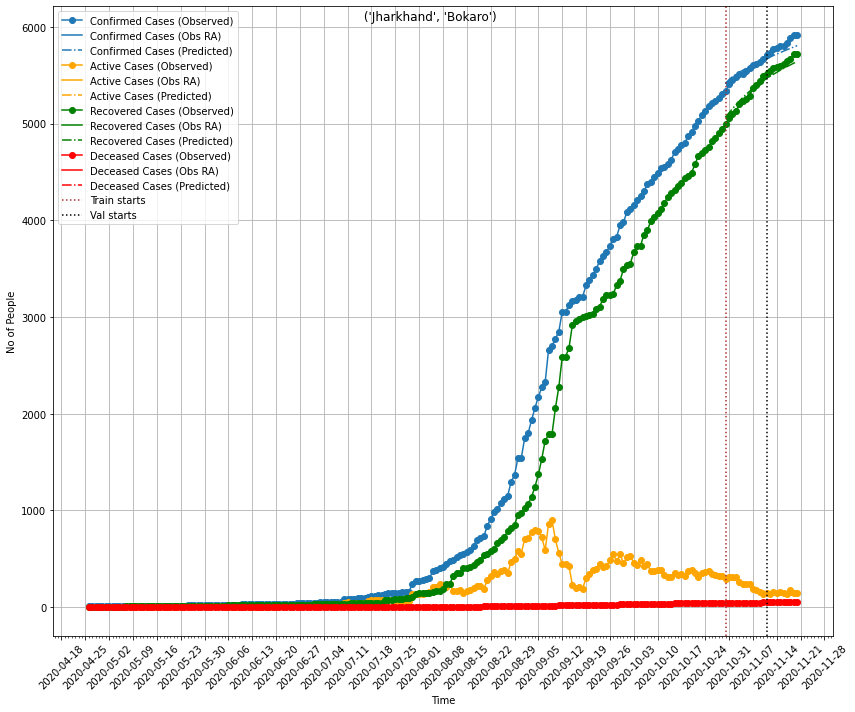

In [7]:
predictions_dict['m0'] = single_fitting_cycle(**m0_params)

In [8]:
config_0 = copy.deepcopy(config)
config_0['uncertainty']['uncertainty_params']['which_fit']='m0'

In [9]:
predictions_dict['m0']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m0', 
                                                                 model=config_0['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 108.82it/s]getting forecasts ..
1000it [00:13, 76.65it/s]


In [10]:
uncertainty_args = {'predictions_dict': predictions_dict, **config_0['uncertainty']['uncertainty_params']}
uncertainty = config_0['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:57<00:00,  1.74trial/s, best loss: 4.584903875579796]


In [11]:
predictions_dict['m0']['forecasts'] = {}

uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m0']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m0']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

predictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


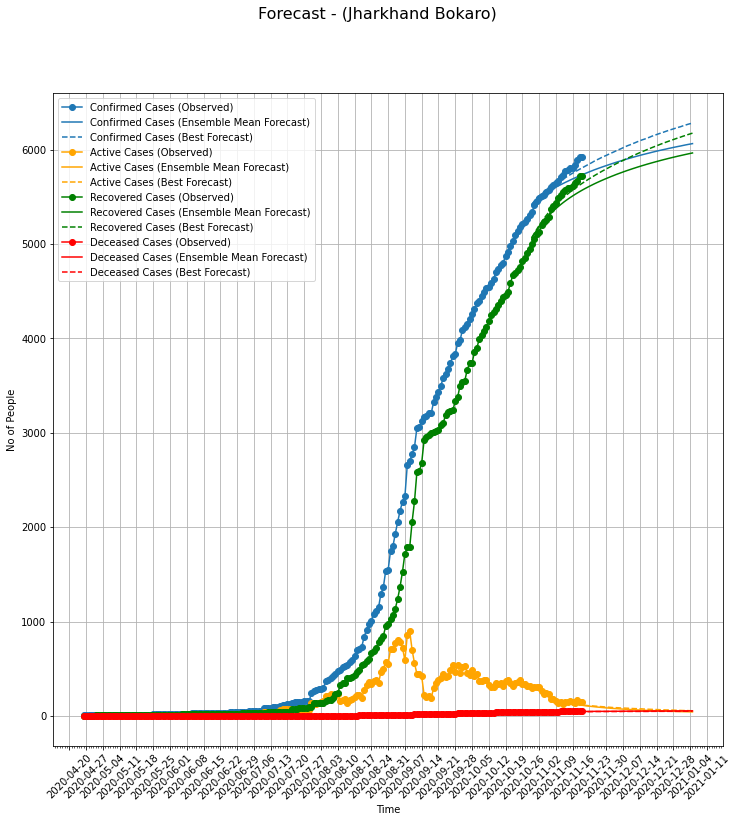

In [12]:
predictions_dict['m0']['plots']['forecast_ensemble_mean_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit='m0', fits_to_plot =['ensemble_mean', 'best'],
            error_bars=True) 

## Performing M1 and M2 fits

Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-26  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
4   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
..         ...        ...      ...    ...     ...        ...       ...   
204 2020-11-16  Jharkhand   Bokaro   5808     146       5612        50   
205 2020-11-17  Jharkhand   Bokaro   5834     136       5648        50   
206 2020-11-18  Jharkhand   Bokaro   5887     173       5664        50   
207 2020-11-19  Jharkhand   Bokaro   5917     147       5719        51   
208 2020-11-20  Jharkhand   Bokaro   5917     147       5719    

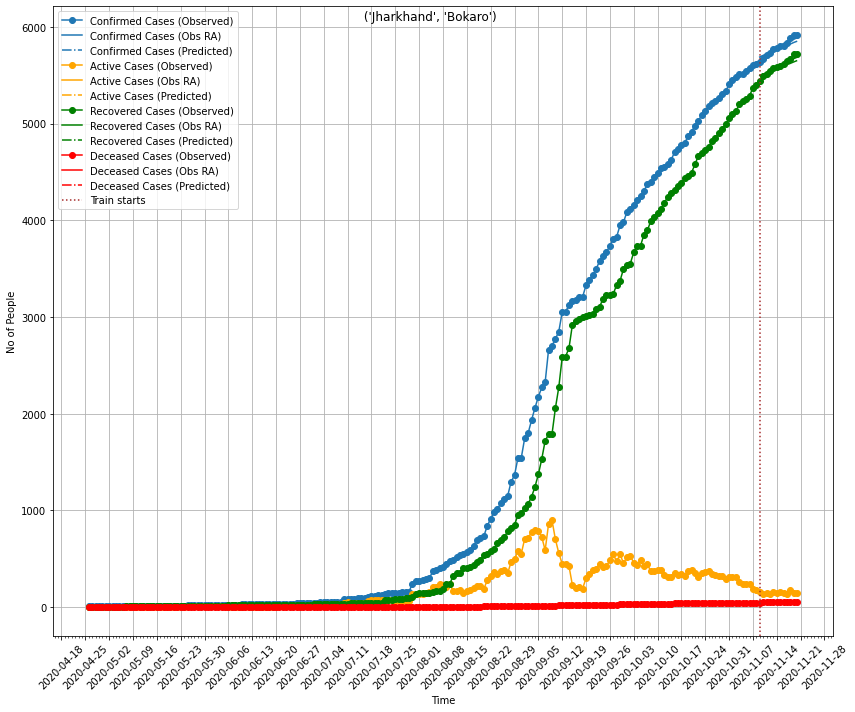

In [13]:
predictions_dict['m1'] = single_fitting_cycle(**m1_params) 

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_20112020_tracker.pkl
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-26  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
4   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
..         ...        ...      ...    ...     ...        ...       ...   
204 2020-11-16  Jharkhand   Bokaro   5808     146       5612        50   
205 2020-11-17  Jharkhand   Bokaro   5834     136       5648        50   
206 2020-11-18  Jharkhand   Bokaro   5887     173       5664        50   
207 2020-11-19  Jharkhand   Bokaro   5917     147       5719        51   
208 2020-11-20  Jharkhand   Bokaro   5917     147       5719    

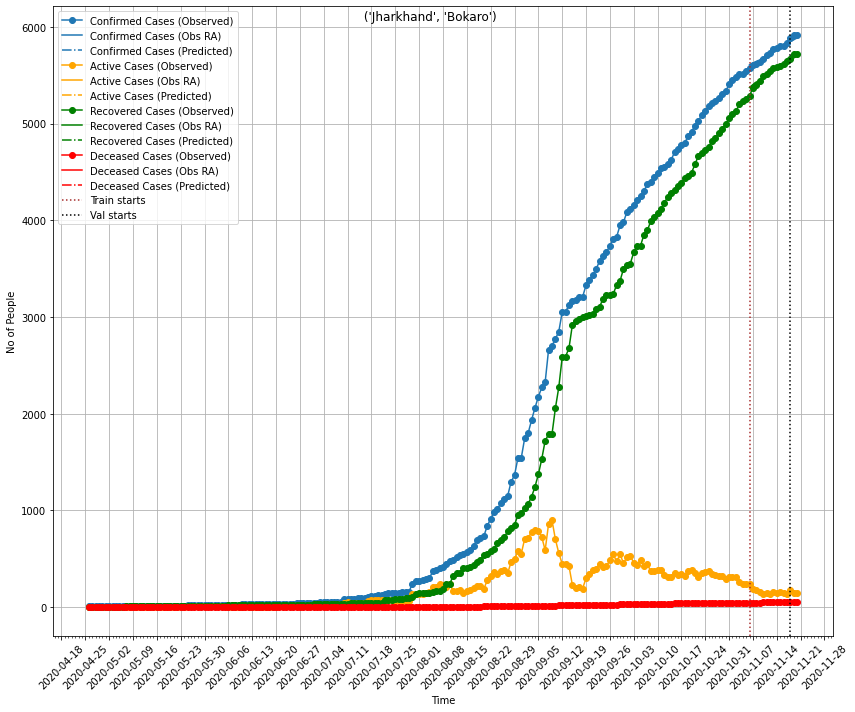

In [14]:
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

In [15]:
predictions_dict['m0']['best_params']

{'E_hosp_ratio': 0.04904880014062087,
 'I_hosp_ratio': 0.44726841316940247,
 'P_fatal': 0.006624513588800543,
 'T_inc': 4.702977105405234,
 'T_inf': 3.2164614446974995,
 'T_recov': 6.823881325120764,
 'T_recov_fatal': 35.27977654044261,
 'lockdown_R0': 0.8921220528527677}

In [16]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.5260515485676114,
 'I_hosp_ratio': 0.39496163187662914,
 'P_fatal': 0.05457523927107745,
 'T_inc': 4.4095191691699425,
 'T_inf': 3.614367293407839,
 'T_recov': 9.769982662260363,
 'T_recov_fatal': 37.97901835198476,
 'lockdown_R0': 0.8488088548290277}

In [17]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.6905317793651977,
 'I_hosp_ratio': 0.23469629675212625,
 'P_fatal': 0.0763485693916133,
 'T_inc': 4.317886176232534,
 'T_inf': 3.118135181125278,
 'T_recov': 5.536677055547852,
 'T_recov_fatal': 38.14171628282008,
 'lockdown_R0': 0.8455514475312357}

## Loss Dataframes

## M0 Loss Dataframe

In [18]:
predictions_dict['m0']['df_loss']

train       val     test
total      0.475072  0.881795  1.46662
active      8.45847   9.76603  14.3943
recovered  0.790452   1.02158  1.06744
deceased   0.524527   6.08163  6.52661

### M1 Loss DataFrame

In [19]:
predictions_dict['m1']['df_loss']

train
total      0.562333
active      5.35378
recovered  0.579981
deceased    1.01744

### M2 Loss DataFrame

In [20]:
predictions_dict['m2']['df_loss']

train       val
total      0.268902  0.660209
active      7.26167   12.8321
recovered  0.386485  0.361595
deceased    1.19151   4.60131

## Sensitivity Plot

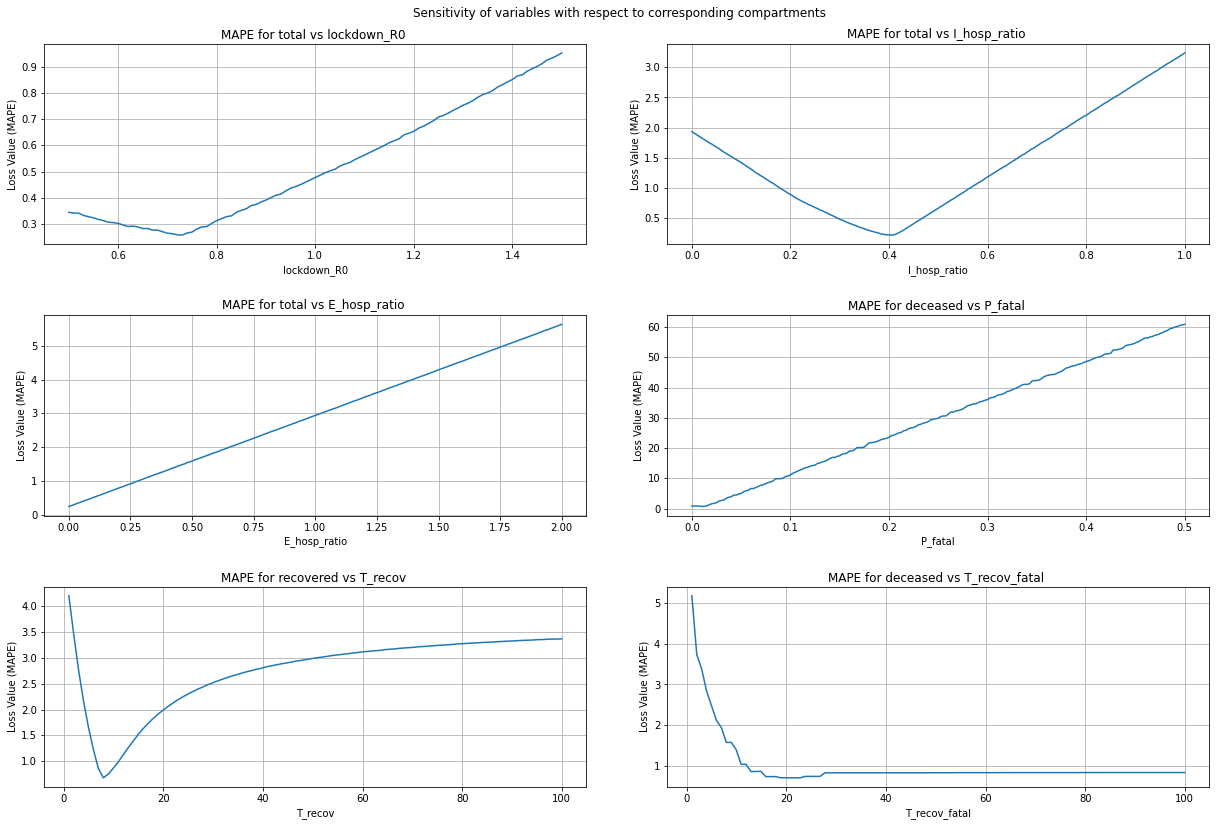

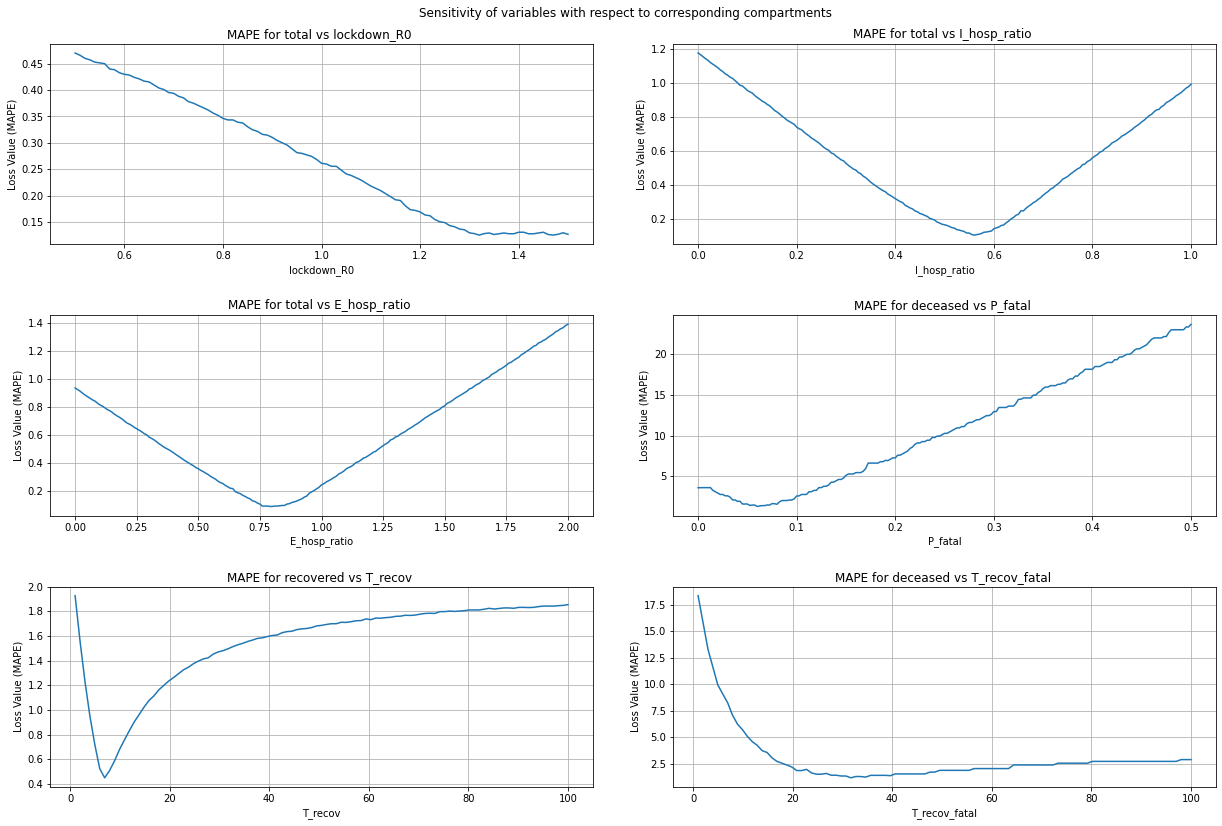

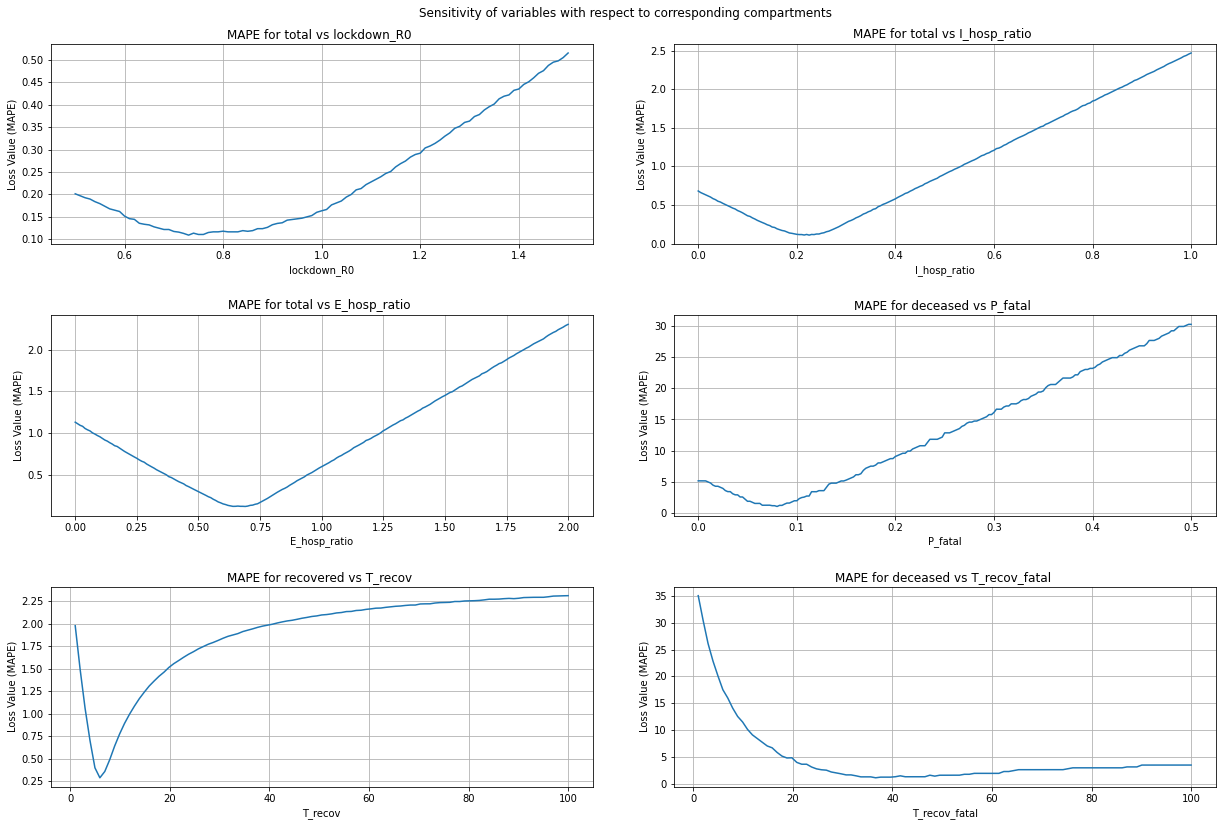

In [21]:
predictions_dict['m0']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m0')
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [22]:
'''
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m0']['forecasts'] = {}
predictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days']
'''

"\n# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)\npredictions_dict['m0']['forecasts'] = {}\npredictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', \n                                                           model=config['fitting']['model'], \n                                                           days=config['forecast']['forecast_days']\n"

In [23]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m1']['forecasts'] = {}
predictions_dict['m1']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


In [24]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


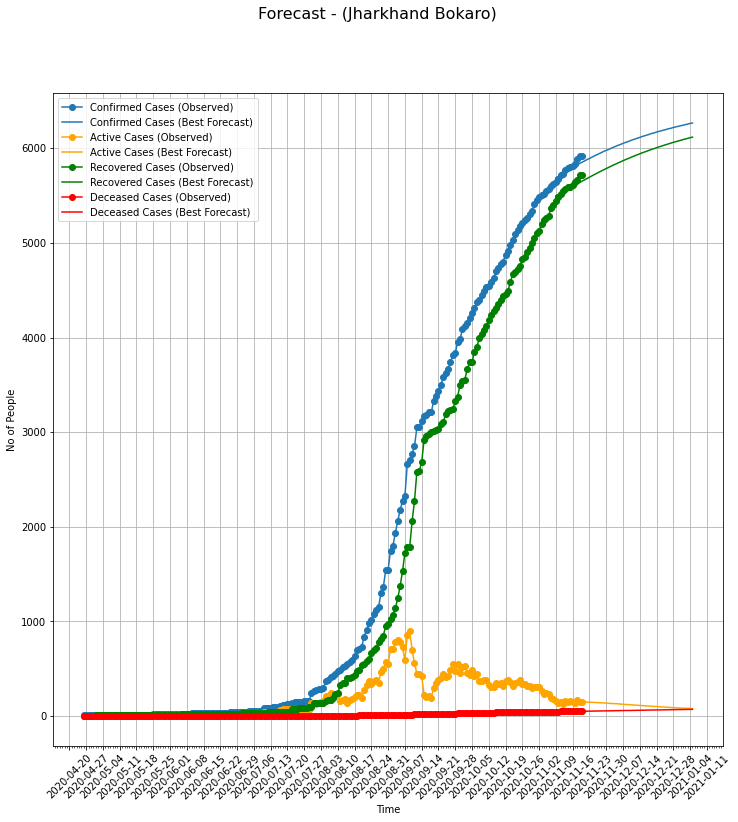

In [25]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m1']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit='m1',
            error_bars=True)

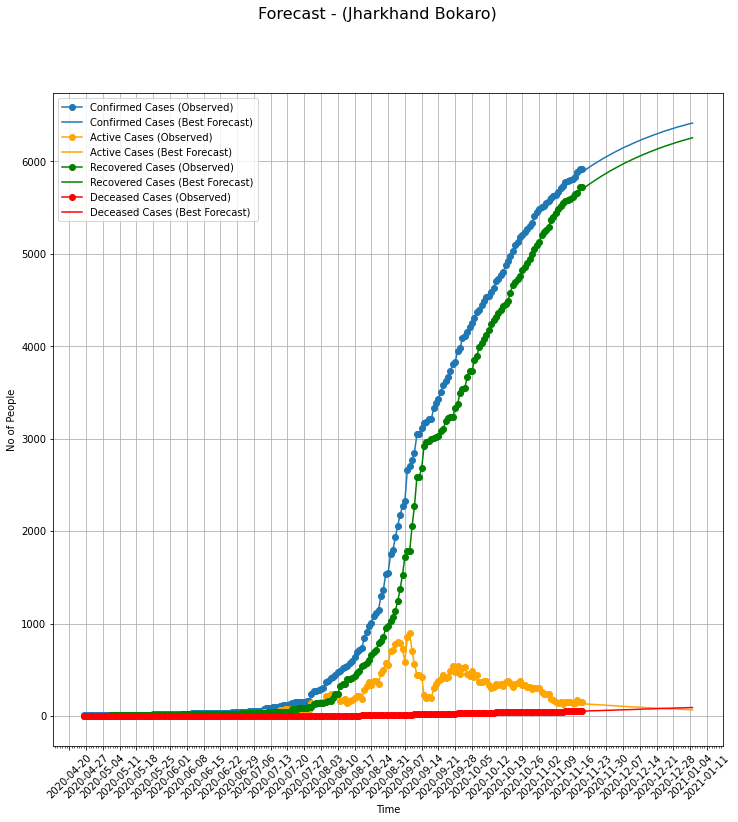

In [26]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit = 'm2',
            error_bars=True)

In [27]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 107.46it/s]getting forecasts ..
1000it [00:06, 143.62it/s]


In [28]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

14it [00:00, 133.67it/s]getting forecasts ..
1000it [00:08, 119.36it/s]


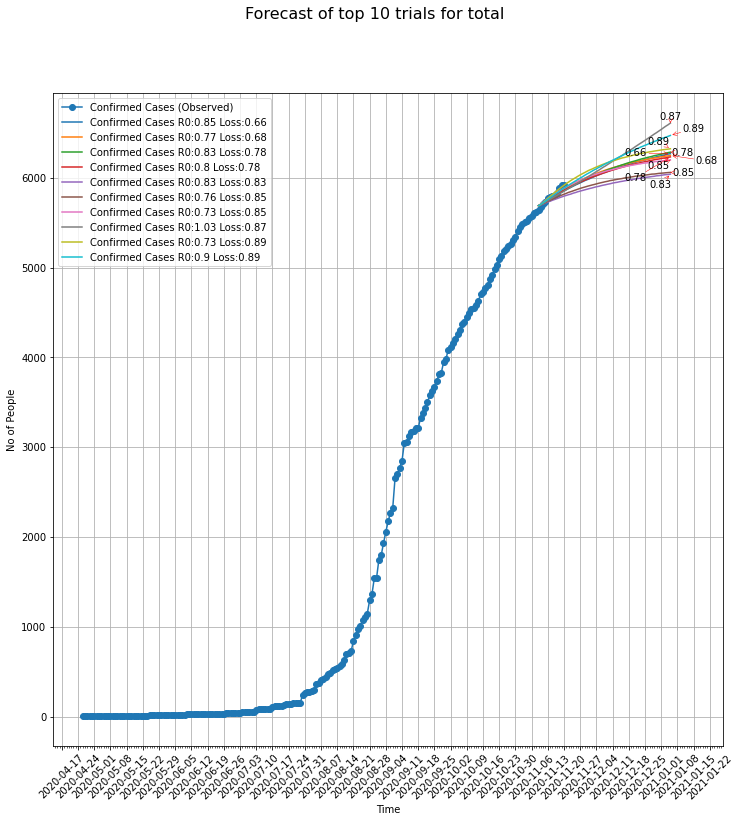

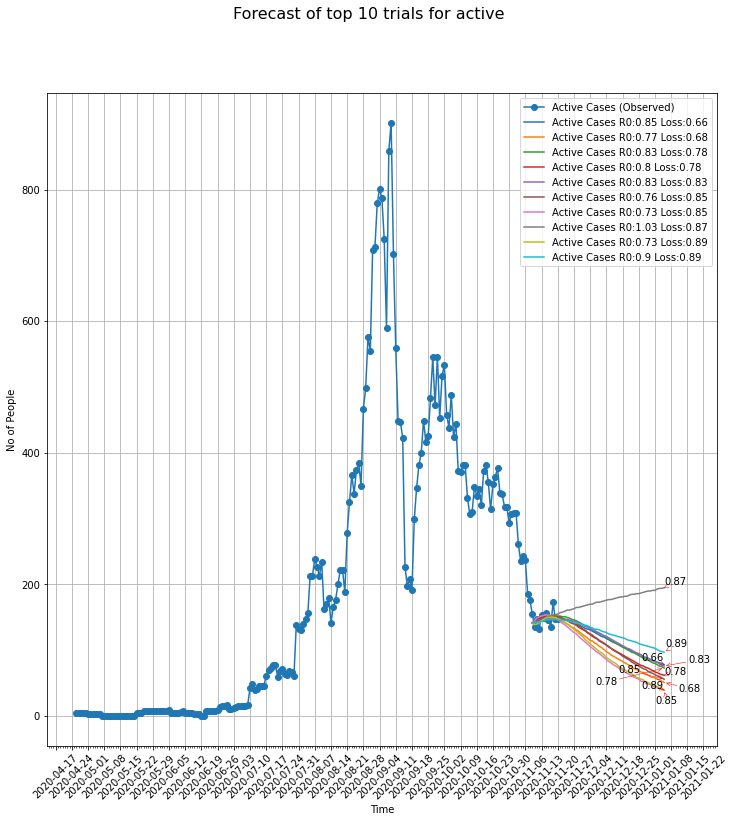

In [29]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m1',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [30]:
predictions_dict['m1']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m1']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [31]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:44<00:00,  2.23trial/s, best loss: 3.077273216307999]


In [32]:
uncertainty.beta_loss

{'active': 4.989870135620765,
 'recovered': 1.4383420137482907,
 'deceased': 4.385462280529103,
 'total': 1.4954184353338367}

In [33]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [34]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

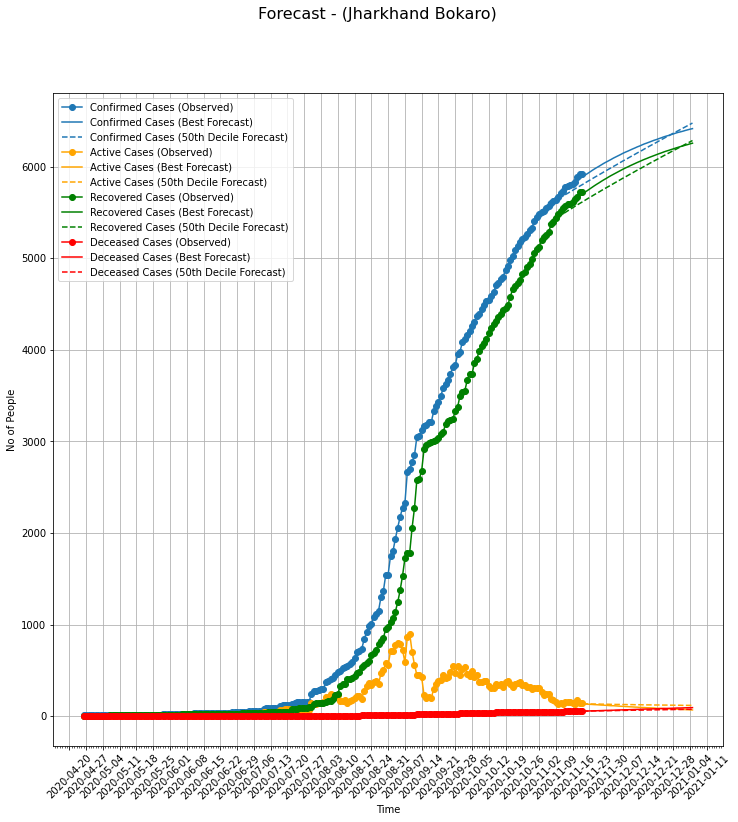

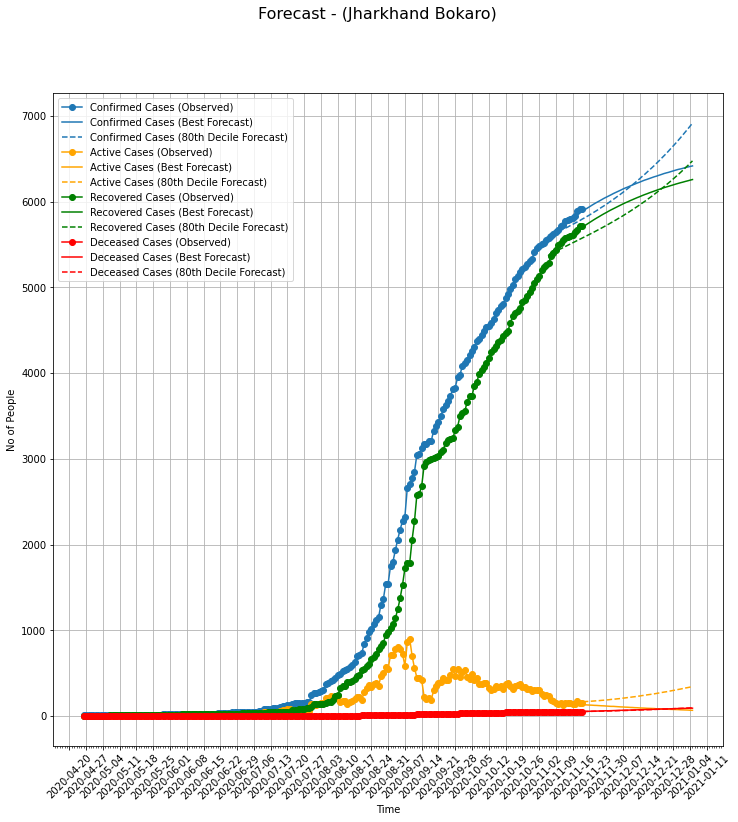

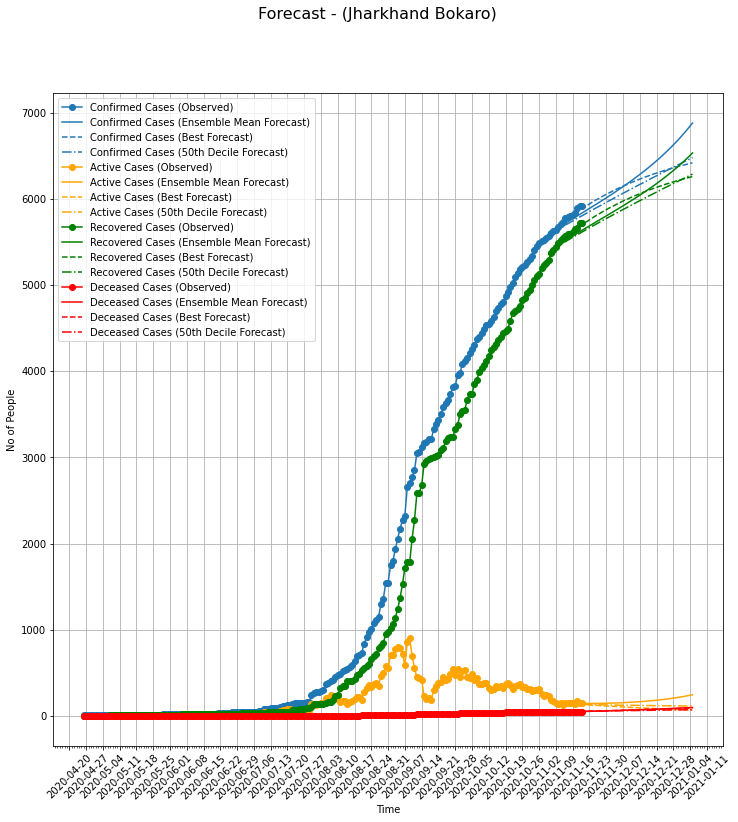

In [35]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 'best', 50], error_bars=False)

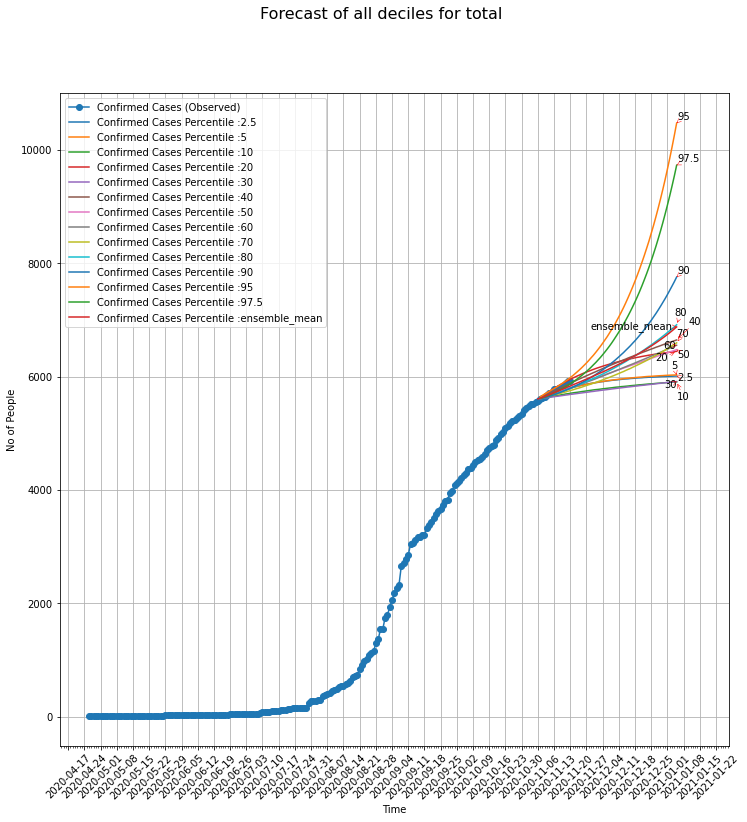

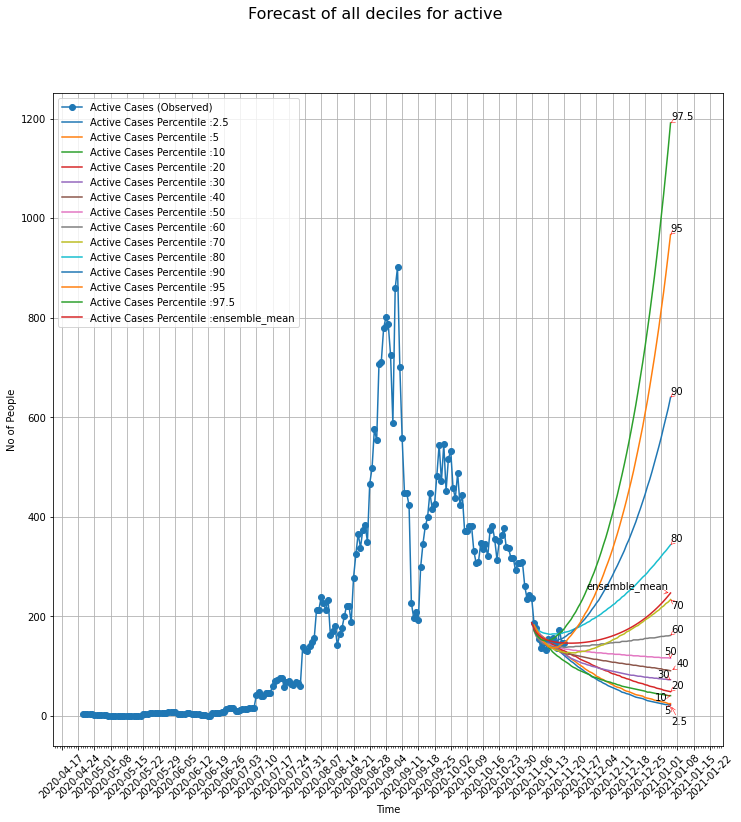

In [36]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


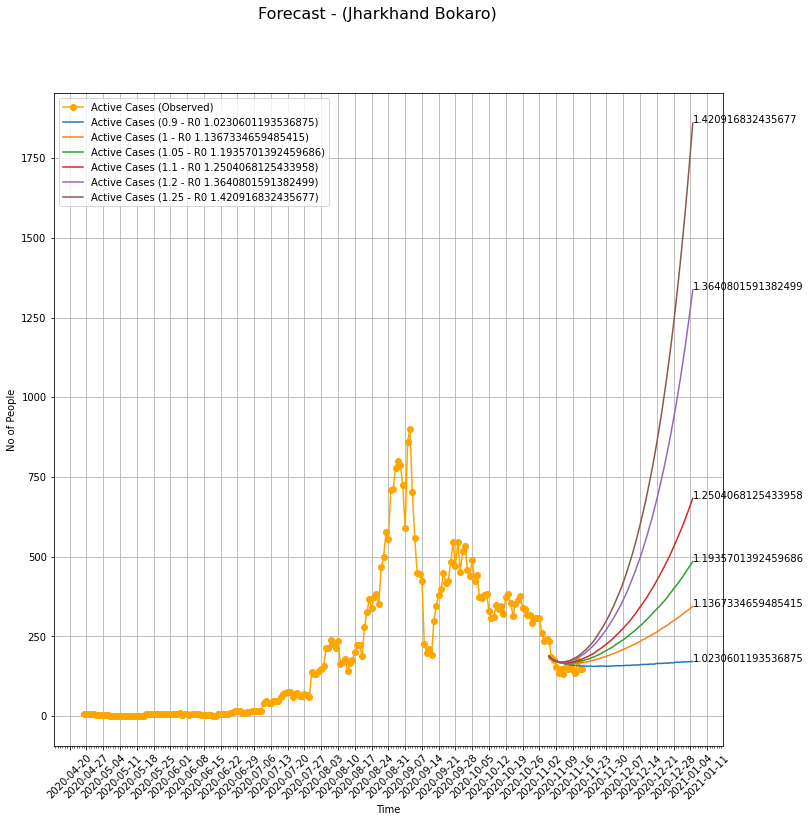

In [37]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Plot Trends on ground

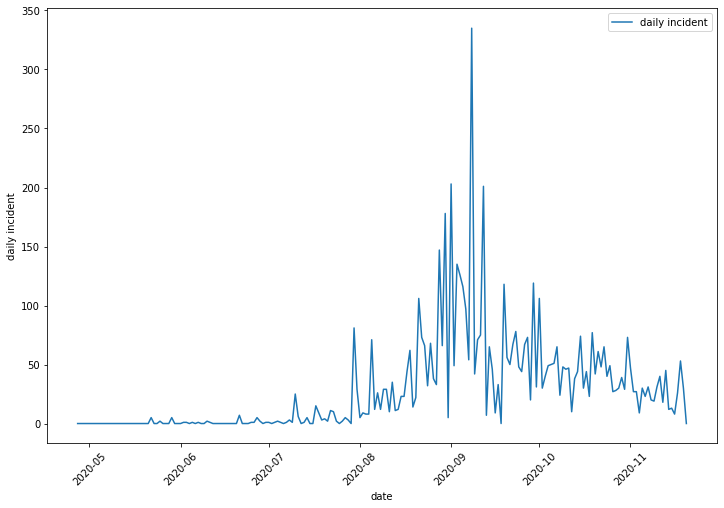

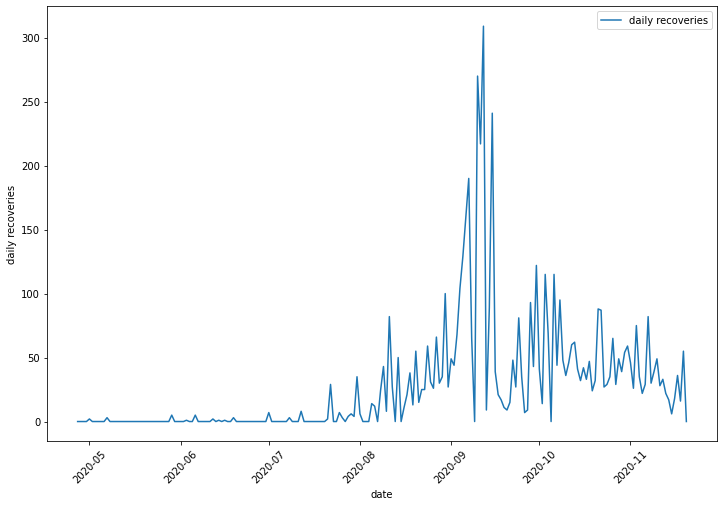

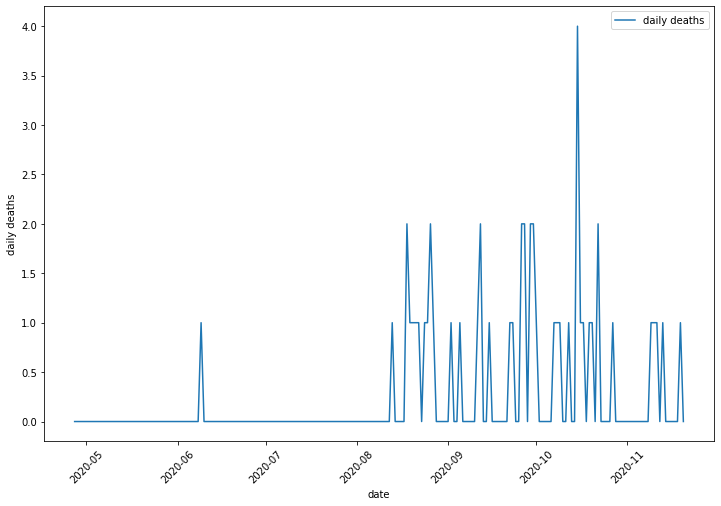

In [38]:
predictions_dict['m0']['plots']['trends'] = {}
predictions_dict['m0']['plots']['trends']['daily_incident'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='incident')
predictions_dict['m0']['plots']['trends']['daily_recoveries'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='recoveries')
predictions_dict['m0']['plots']['trends']['daily_deaths'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='deaths')

## Create Report

In [39]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [40]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [41]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [42]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [43]:
save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)

## Create df_district Output

In [44]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')